In [5]:
# Install TensorFlow
#!pip install tensorflow

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)



`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0


In [0]:
# additional imports

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# Load Data

In [0]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


# Data Preprocessing

In [0]:
# Normalize data
x_train, x_test = x_train / 255, x_test / 255

In [0]:
# Reshape targets to be vectors
y_train = y_train.flatten()
y_test = y_test.flatten()

# Get number of classes
K = len(set(y_train))

# Build Model

In [0]:
i = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i) # padding='same' keeps output image size the same
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x) # halve image size
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x) # halve image size
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x) # halve image size

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
#early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

In [12]:
# Data augmentation
batch_size = 64
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496 

In [13]:
# Fit model
r = model.fit(train_generator, 
              validation_data=(x_test, y_test), 
              steps_per_epoch=steps_per_epoch, 
              epochs=60)

Epoch 1/60
781/781 [==============================] - 24s 31ms/step - loss: 1.4756 - accuracy: 0.4901 - val_loss: 1.2557 - val_accuracy: 0.5512
Epoch 2/60
781/781 [==============================] - 24s 31ms/step - loss: 0.9753 - accuracy: 0.6561 - val_loss: 0.9601 - val_accuracy: 0.6660
Epoch 3/60
781/781 [==============================] - 24s 31ms/step - loss: 0.8134 - accuracy: 0.7163 - val_loss: 0.8493 - val_accuracy: 0.7072
Epoch 4/60
781/781 [==============================] - 24s 31ms/step - loss: 0.7225 - accuracy: 0.7511 - val_loss: 0.8449 - val_accuracy: 0.7182
Epoch 5/60
781/781 [==============================] - 24s 31ms/step - loss: 0.6632 - accuracy: 0.7733 - val_loss: 0.6573 - val_accuracy: 0.7747
Epoch 6/60
781/781 [==============================] - 24s 31ms/step - loss: 0.6096 - accuracy: 0.7888 - val_loss: 0.7527 - val_accuracy: 0.7531
Epoch 7/60
781/781 [==============================] - 24s 31ms/step - loss: 0.5776 - accuracy: 0.8032 - val_loss: 0.7474 - val_accuracy:

# Evaluate Model

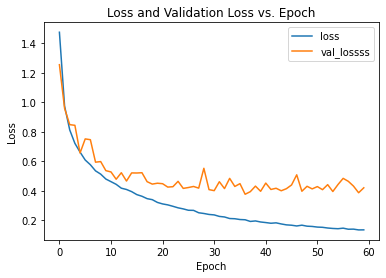

In [19]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_lossss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

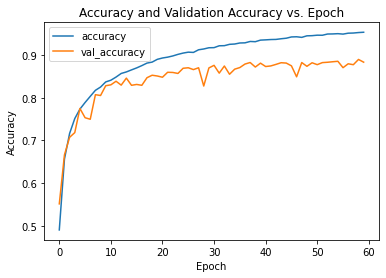

In [20]:
# Plot the accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(33.0, 0.5, 'True Label')

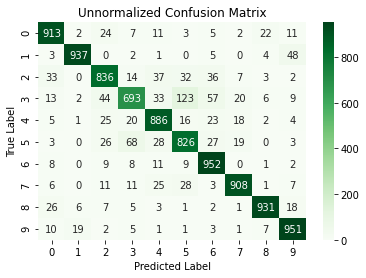

In [16]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_test).argmax(axis=1) # Need to take argmax to get class number with highest probability for each sample
colormap = confusion_matrix(y_test, predictions)
import seaborn as sns
ax = sns.heatmap(colormap, annot=True, fmt='d', cmap='Greens')
ax.set_title("Unnormalized Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

In [0]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

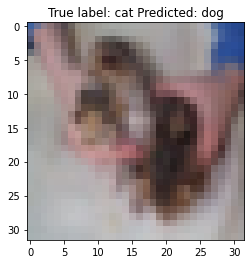

In [18]:
# Show some misclassified examples
misclassified_idx = np.where(predictions != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[predictions[i]]));